# PRESENTATION
This notebook uses some personal data on ATP tennis matches since 2016.
The **data** includes a lot of common statistics about each match:
- result
- score
- points won on serve
- CourtId: 1 to 6: "Hard", "Clay", "Indoor", "Carpet", "Grass", "Acrylic"
- aces...

Each match is made of 2 rows:
- the first row contains the stats for the first player
- the second row for the second player

It also includes some personal stats I made:
- AvgAceRateP: the average ace rate of the player (on clay or non clay surface) before the match. It is calculated from all the matches on this specficic surface over the past 3 seasons and weighted by date of season.
- AvgAceRateOpp: the average conceded ace rate of the opponent (on clay or non clay surface) before the match. It is calculated from all the matches on this specficic surface over the past 3 seasons and weighted by date of season.
- TrnSpeed: the speed fo the tournament (standard speed is 1.0)

The **goal** here is to find the best way to **predict the actual rate of a player one match** from the 3 features above.
We will use the actual ace rate of a match to train the model.

In [1]:
def get_query_surface(index_surface: str)->str:
    """Return the clause of the query for the surface
    Example: 'CourtId=="Clay" '
    Parameters
    ----------
    index_surface : str
        And index between 0 and 4 for the surface
        (NonClay=0,Clay=1,Hard=2,Indoor=3,Grass=4)
    Raises
    ------
    Exception
        If no sound is set for the animal or passed in as a
        parameter.
    """
    index_surface = str(index_surface)
    str_clause_surface = ''
    if (index_surface =='1'):
        strClauseSurface = 'CourtId=="2" '
    elif (index_surface =='0'):
        strClauseSurface = 'CourtId!="2" '
    elif (index_surface =='2'):
        strClauseSurface = 'CourtId=="1" '
    elif (index_surface =='3'):
        strClauseSurface = 'CourtId=="3" '
    elif (index_surface =='4'):
        strClauseSurface = 'CourtId=="5" '
    else :
        raise Exception("indexSurface is incorrect for get_query_surface(indexSurface)")# + get_query_surface.__doc__)
    return strClauseSurface

## LOAD Data

In [2]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

#LOAD DATA
yrstart=2017
yrend=2021
dfMatches=pd.DataFrame()
for year in range(yrend, yrstart-1,-1):
    #dfcha=pd.read_csv((r"https://raw.githubusercontent.com/damienld/tennis_atp/master/atp_matches_qual_chall_{0}.csv").format(str(year)),index_col=0)
    dfyear=pd.read_csv(("./Data/ATP{0}_all_matches.csv").format(str(year)), parse_dates = ['Date'])
    dfMatches=pd.concat([dfMatches,dfyear],axis=0)
dfMatches = dfMatches.sort_values(by="Date", ascending=False)   


## FILTER Data
- on user selected surface (input)
- where the aces data are valid

In [3]:
#USER can select the surface
dict_surfaces = {0: "NonClay", 1:"Clay", 2:"Hard", 3: "Indoor",4: "Grass"}
print("SELECT surface:" + str(dict_surfaces))
index_sel = int(input())
print(dict_surfaces.get(index_sel))
strClauseSurface = get_query_surface(index_sel)

#FILTER the dataframe for the Surface
dfMatchesForTrn = dfMatches.copy(deep=True)
#keep only if TrnSpeed > 0
dfMatchesForTrn = dfMatchesForTrn[dfMatchesForTrn['TrnSpeed'] > 0]
dfMatchesForTrn.dropna()
query_filter = strClauseSurface + ' & IsValidData >0 & IsEnoughData3>0 & AvgAceRateP>0  & AvgAceRateOpp>0' # & AceRatePlayer>0
#no qualifying matches and no exhib/DC/juniors and no itf
query_filter += ' & RoundId>=4 & TrnRk <= 4  & TrnRk >= 1' # & AceRatePlayer>0
dfMatchesForTrn = dfMatchesForTrn.replace(np.NaN,-1).query(query_filter)
#print(dfMatchesForTrn)
print('nb matches: ' + str(len(dfMatchesForTrn)))

SELECT surface:{0: 'NonClay', 1: 'Clay', 2: 'Hard', 3: 'Indoor', 4: 'Grass'}
0
NonClay
nb matches: 56154


## X will contain the 3 features:
- AvgAceRateP
- AvgAceRateOpp
- TrnSpeed
## Y will be the actual ace rate
to be predicted from the 3 features

In [4]:
#dfMatchesForTrn=dfMatchesForTrn[(dfMatchesForTrn['AvgAceRateP']>=0) & (dfMatchesForTrn['AvgAceRateP']<5)]
X=dfMatchesForTrn[["AvgAceRateP","AvgAceRateOpp","TrnSpeed","AceRatePlayer"]]
X=X.dropna()
Y=X["AceRatePlayer"]
X=X.drop("AceRatePlayer", axis=1)

# EXPLORATORY DATA ANALYSIS

,AvgAceRateP,AvgAceRateOpp,TrnSpeed
count,56154.000000,56154.000000,56154.000000
mean,7.180277,6.644300,0.982190
std,3.816153,2.343861,0.124194
min,0.600000,1.100000,0.600000
25%,4.500000,4.700000,0.900000
50%,6.300000,6.600000,0.980000
75%,9.100000,8.300000,1.060000
max,26.000000,19.000000,1.500000


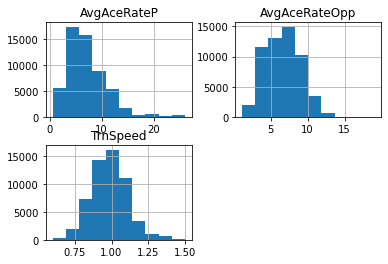

In [5]:
#PLOT
X.hist()
X.describe()    

count    56154.000000
mean         7.050563
std          5.888083
min          0.000000
25%          2.800000
50%          5.700000
75%          9.800000
max         58.300000
Name: AceRatePlayer, dtype: float64

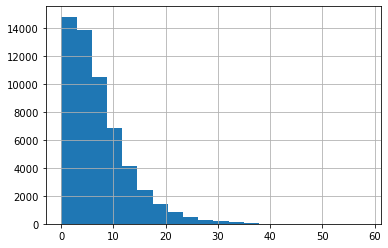

In [6]:
Y.hist(bins=20)
Y.describe()    

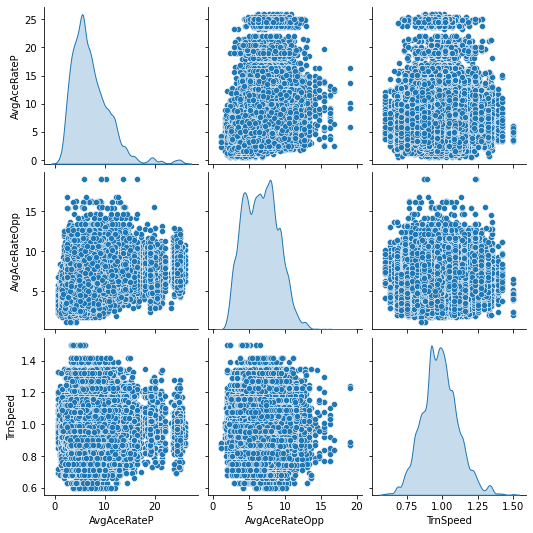

In [7]:
import seaborn as sns
sns.pairplot(X, diag_kind="kde")

# ANALYSIS of the couples: AvgAceRateP, AvgAceRateOpp
WHAT is the median of AceRatePlayer for each couple of features:
STEPS:
- round the values so they can be groupped
- make a pivot table indexed by AvgAceRateP,AvgAceRateOpp
- keep only when the number of rows is a minimum (20)

In [18]:
dfMatchesForTrn2=dfMatchesForTrn[["AceRatePlayer","AvgAceRateP","AvgAceRateOpp"]]
#round the values
#dfMatchesForTrn2.AceRatePlayer=dfMatchesForTrn2.AceRatePlayer.round()
dfMatchesForTrn2.AvgAceRateP=dfMatchesForTrn2.AvgAceRateP.round()
dfMatchesForTrn2.AvgAceRateOpp=dfMatchesForTrn2.AvgAceRateOpp.round()
#Make a pivot table indexed by the differents couples of features
dfpivot_aces=pd.pivot_table(dfMatchesForTrn2,index=["AvgAceRateP","AvgAceRateOpp"],aggfunc=["median", "count"])
#Keep only when the number of rows is a minimum
dfpivot_aces=dfpivot_aces[dfpivot_aces["count"]["AceRatePlayer"]>20]
dfpivot_aces=dfpivot_aces.reset_index()
dfpivot_aces[dfpivot_aces.AvgAceRateOpp==8].head(22)

D:\Programmes\Anaconda\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,AvgAceRateP,AvgAceRateOpp,median,count
,,,AceRatePlayer,AceRatePlayer
11,2.0,8.0,2.55,158
20,3.0,8.0,2.90,334
30,4.0,8.0,3.90,673
42,5.0,8.0,4.80,947
54,6.0,8.0,5.80,1287
66,7.0,8.0,6.90,1008
78,8.0,8.0,7.55,1098
89,9.0,8.0,8.70,692
100,10.0,8.0,9.20,760


- We knew the average of aces is about8.0

HYPOTHESIS
- So when AvgAceRateOpp=8 we should see that AceRatePlayer=AvgAceRateP (because the 2nd feature is at the median and shouldnt impact much because the level of the opponent is really neutral)

CONLUSION
- Indeed for most couples we've got (AvgAceRateP, 8)=AceRatePlayer

# LINEAR REGRESSION

EVALUATION
we compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics provide a key role in the development of a model, as it provides insight to areas that require improvement.

METRICS:
- Mean absolute error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
- Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean absolute error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.
- Root Mean Squared Error (RMSE): R-squared is not error, but is a popular metric for accuracy of your model. It represents how close the data are to the fitted regression line. The higher the R-squared, the better the model fits your data. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

In [9]:
from sklearn.metrics import r2_score

def print_metrics(Y_test, y_pred):    
    print('Mean absolute error: %.2f' % np.mean(np.absolute(y_pred - Y_test)))
    print('Residual sum of squares (MSE): %.2f' % np.mean((y_pred - Y_test) **2 ))
    print('R2-score: %.2f' % r2_score(Y_test, y_pred))

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=125)
lm=LinearRegression()
lm.fit(X_train, Y_train)
print(X.head())
#RESULTS
print('RESULTS FOR COURT:')
coeffsLRegression=lm.coef_
print(coeffsLRegression)
#print(pd.DataFrame({'estimated coeff':coeffsRegression}, index=X_train.columns))
coeff0LRegression= lm.intercept_
print(coeff0LRegression)
y_pred=lm.predict(X_test)
print_metrics(Y_test, y_pred)

      AvgAceRateP  AvgAceRateOpp  TrnSpeed
1053          8.1            9.2      1.33
1055          3.3            2.9      0.69
1056          4.0            5.8      0.69
1057          5.7            6.8      0.69
1058          9.6           11.2      0.88
RESULTS FOR COURT:
[0.88238701 0.52990738 9.04398716]
-11.691765211621084
Mean absolute error: 3.09
Residual sum of squares (MSE): 17.40
R2-score: 0.51


# POLYNOMIAL REGRESSION (best model)

In [20]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_poly, Y, test_size=0.25, random_state=125)
lm=LinearRegression()
lm.fit(X_train, Y_train)

#RESULTS
print('RESULTS FOR COURT:')
coeffsRegression=lm.coef_
print('COEFFS AceP(1) AceOpp(2) Trn(3) AceP**2(4) AceP*AceOpp(5) AceP*Trn(6) AceOpp**2(7) AceOpp*Trn(8) Trn**2(9)\n'+ str(coeffsRegression))
#print(pd.DataFrame({'estimated coeff':coeffsRegression}, index=X_train.columns))
coeff0Regression= lm.intercept_
print(coeff0Regression)
y_pred=lm.predict(X_test)

print_metrics(Y_test, y_pred)

RESULTS FOR COURT:
COEFFS AceP(1) AceOpp(2) Trn(3) AceP**2(4) AceP*AceOpp(5) AceP*Trn(6) AceOpp**2(7) AceOpp*Trn(8) Trn**2(9)
[-3.56606009e-01 -7.54711030e-01 -4.95788450e+00  1.27365711e-03
  6.90081486e-02  7.31315904e-01  1.69787657e-02  6.02201251e-01
  2.31883682e+00]
3.6824196461491554
Mean absolute error: 3.03
Residual sum of squares (MSE): 16.84
R2-score: 0.52


Let's **apply the regression coefficients** (lienar regression and polynomial regression) on our table dfpivot_aces.

We'll apply TrnSpeed=1 as it s the standard value (mean/median)

In [21]:
trnSpeed=1
dfpivot_aces["expAces_reg"] = [(coeff0LRegression+ace*coeffsLRegression[0]+acevs*coeffsLRegression[1]+trnSpeed*coeffsLRegression[2]) for (ace, acevs) in zip(dfpivot_aces.AvgAceRateP, dfpivot_aces.AvgAceRateOpp)]
dfpivot_aces["expAces_poly"] = [(coeff0Regression+ace*coeffsRegression[0]+acevs*coeffsRegression[1]+trnSpeed*coeffsRegression[2]+ace**2*coeffsRegression[3]+ace*acevs*coeffsRegression[4]+ace*trnSpeed*coeffsRegression[5]+acevs**2*coeffsRegression[6]+acevs*trnSpeed*coeffsRegression[7]+trnSpeed**2*coeffsRegression[8]) for (ace, acevs) in zip(dfpivot_aces.AvgAceRateP, dfpivot_aces.AvgAceRateOpp)]
dfpivot_aces["expAces_reg_gap"] = (dfpivot_aces["median"]["AceRatePlayer"]-dfpivot_aces["expAces_reg"]).abs()
dfpivot_aces["expAces_poly_gap"] = (dfpivot_aces["median"]["AceRatePlayer"]-dfpivot_aces["expAces_poly"]).abs()
dfpivot_aces.iloc[21:40,:]

,AvgAceRateP,AvgAceRateOpp,median,count,expAces_reg,expAces_poly,expAces_reg_gap,expAces_poly_gap
,,,AceRatePlayer,AceRatePlayer,,,,
21,3.0,9.0,2.80,151,4.768549,4.044877,1.968549,1.244877
22,3.0,10.0,3.35,98,5.298457,4.421988,1.948457,1.071988
23,3.0,11.0,3.90,33,5.828364,4.833057,1.928364,0.933057
24,4.0,2.0,1.80,245,1.941585,2.877551,0.141585,1.077551
25,4.0,3.0,2.10,874,2.471492,3.085967,0.371492,0.985967
26,4.0,4.0,3.00,1803,3.001400,3.328342,0.001400,0.328342
27,4.0,5.0,3.60,1138,3.531307,3.604673,0.068693,0.004673
28,4.0,6.0,3.60,1016,4.061214,3.914963,0.461214,0.314963
29,4.0,7.0,3.70,585,4.591122,4.259209,0.891122,0.559209


# Application of Decision Tree regression

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=125)

dt_regressor = DecisionTreeRegressor(random_state = 125)
dt_regressor.fit(X_train,Y_train)
#Predicting using test set 
y_pred = dt_regressor.predict(X_test)

print_metrics(Y_test, y_pred)

Mean absolute error: 4.24
Residual sum of squares (MSE): 33.02
R2-score: 0.07


# Application of Random Forest Regression

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators = 30 ,  random_state = 125)
rf_regressor.fit(X_train,Y_train)
#Predicting the SalePrices using test set 
y_pred = rf_regressor.predict(X_test)

print_metrics(Y_test, y_pred)

Mean absolute error: 3.31
Residual sum of squares (MSE): 19.91
R2-score: 0.44


# Application of Support Vector Regression

In [15]:
from sklearn.svm import SVR
regressor= SVR(kernel='rbf')
regressor.fit(X_train,Y_train)
y_pred_svm=regressor.predict(X_test)
#y_pred_svm = cross_val_predict(regressor, x, y)

print_metrics(Y_test, y_pred)

Mean absolute error: 3.31
Residual sum of squares (MSE): 19.91
R2-score: 0.44


# TODO

# Application of Deep Learning using Keras library
Here is the deep learning model mentioned. A sequential model has been used. The model has been created as a function named build_model so that we can call it anytime it is required in the process. The model has two connected hidden layers with a Rectified Linear Unit (relu) function and an output layer with a linear function.

The hidden layers have 12 and 8 neurons respectively with all the 8 input variables. Mean Squared Error is the loss function here as it is the most common loss function in case of regression problems.

#TODO
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(12,kernel_initializer='normal', activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()
model.summary()

def indexCoeff0ByCourt(nameCourt):
    switcher={
            'Clay':2,
            'Grass':3,
            'Hard':4,
            'I.hard':5
            }
    return switcher.get(nameCourt)

class TournamentStats:
    def __init__(self,id,dateT, name, speed, court,level,location
                 , sumActual, sumExp, nbMatches, coeff0Regression, coeffRegAceFor,coeffRegAceVs):
        self.id=id
        self.dateT = dateT
        self.name = name
        self.speed = speed
        self.court = court
        self.level=level
        self.location=location
        self.sumActual=sumActual
        self.sumExp=sumExp
        self.nbMatches=nbMatches
        self.coeff0Regression=coeff0Regression
        self.coeffRegAceFor=coeffRegAceFor
        self.coeffRegAceVs=coeffRegAceVs
    def __repr__(self):
        return '{},{},{},{},{},{},{},{},{},{},{},{},{}'.format(self.name,self.id,round(self.speed,2),
                                    self.dateT, self.court, self.level, self.location,
                                    round(self.sumActual,2), round(self.sumExp,2), self.nbMatches,
                                    round(self.coeff0Regression,2),round(self.coeffRegAceFor,2)
                                    ,round(self.coeffRegAceVs,2))
    def __cmp__(self, other):
        if hasattr(other, 'speed'):
            return self.speed.__cmp__(other.speed)
    def isCourt(self, courtName):
        return (courtName==self.court)
    @staticmethod
    def FilterByCourtName(list, courtName):
        return filter(isCourt(courtName), list)

def getTrnsSpeeds(listTrnIds, dataFromFile, coeffsRegression, coeff0Regression):
"""
Calculate the Speed of a Tournament (difference between Actual Aces and Expectes Aces)
"""
    listTrn=[]
    for trnId in listTrnIds:
        strClauseTrn = 'TrnId=='+str(trnId)+' & '
        dfMatchesForTrn=dataFromFile.copy(deep=True)
        dfMatchesForTrn.dropna()
        dfMatchesForTrn = dfMatchesForTrn.replace('NaN',-1).query(strClauseTrn + 'IsValidData>0 & IsEnoughData>0 & AceRatePlayer>=0 & AvgAceRateP>0  & AvgAceRateOpp>0')
        courtCoeff0Reg = 0
        #print('Coeff0 for Court=' + str(courtCoeff0Reg))
        #surface not taken into account here!! else add courtCoeff0Reg below
        expectedAce = (courtCoeff0Reg+coeff0Regression+coeffsRegression[0]*dfMatchesForTrn['AvgAceRateP']+coeffsRegression[1]*dfMatchesForTrn['AvgAceRateOpp'])
        expectedAce= [max(t, 0.01) for t in expectedAce]  #no negative values
        #diff=df['AceRatePlayer']-expectedAce
        #diff= max(diff, 0.01)
        sumActual=sum(dfMatchesForTrn['AceRatePlayer'])
        sumExp=sum(expectedAce)
        #print(df.iloc[0,2]+':'+str(statistics.mean(diff)))
        #print('Sum Ace Rates:'+str(sumActual))
        #print('Sum Exp Rates:'+str(sumExp))
        #print(df.iloc[0,0] + df.iloc[0,2]+'Diff:'+str(sumActual/sumExp))
        trn=TournamentStats(dfMatchesForTrn.iloc[0,0], dfMatchesForTrn.iloc[0,1], dfMatchesForTrn.iloc[0,2]
                            , sumActual/sumExp, dfMatchesForTrn.iloc[0,5]
                            , dfMatchesForTrn.iloc[0,3], dfMatchesForTrn.iloc[0,4], sumActual, sumExp
                            , len(dfMatchesForTrn), coeff0Regression, coeffsRegression[0],coeffsRegression[1])
        #print(trn)
        listTrn.append(trn)
    #listTrnClay=[t for t in listTrn if (x.isCourt('Clay'))]
    #listTrnClay=filter(lambda x: x.isCourt('Clay'), listTrn)
    #list(listTrnClay)
    #listTrnClay.sort(key=lambda x: x.speed, reverse=True)
    #sorted(listTrnClay, key=lambda x: x.speed, reverse=True)
    listTrn.sort(key=lambda x: x.name, reverse=True)
    print(*listTrn, sep="\n")
    #listTrNonClay=list(filter(lambda x: not x.isCourt('Clay'), listTrn))
    #sorted(listTrNonClay, key=lambda x: x.speed, reverse=True)
    #print(*listTrNonClay, sep="\n")

def displayAllMatches(trnId, dataFromFile, coeffsRegression, coeff0Regression):
    df=dataFromFile.copy(deep=True)
    df.dropna()
    df = df.replace('NaN',-1).query('TrnId=='+trnId+' & IsValidData>0 & IsEnoughData>0 & AceRatePlayer>0 & AvgAceRateP>0  & AvgAceRateOpp>0')     
    print(df)
    for index, row in df.iterrows():
        print(row['Player']+' in '+ row['P1'] + '/' + row['P2'])
        courtCoeff0Reg = 0
        expectedAce = (courtCoeff0Reg+coeff0Regression+coeffsRegression[0]*row['AvgAceRateP']+coeffsRegression[1]*row['AvgAceRateOpp'])
        expectedAce= [max(t, 0.01) for t in expectedAce]  #no negative values
        print('Res=' + str(row['AceRatePlayer']) + ' - Expected=' + str(round(expectedAce,2)) + ' From ' + str(row['AvgAceRateP']) +' vs '  + str(row['AvgAceRateOpp']))
        diff=(row['AceRatePlayer']-expectedAce)
        #diff= min(max(diff, 0.01),1.99)
        print(diff)

# PLOTS

s1=[len( (dfMatchesForTrn[ (dfMatchesForTrn.AvgAceRateP.round()==round(valX)) & (dfMatchesForTrn.AceRatePlayer==round(valY))]) )/5 for valX,valY in zip(dfMatchesForTrn.AvgAceRateP,dfMatchesForTrn.AceRatePlayer)]
s2=[len( (dfMatchesForTrn[ (dfMatchesForTrn.AvgAceRateOpp.round()==round(valX)) & (dfMatchesForTrn.AceRatePlayer==round(valY))]) )/5 for valX,valY in zip(dfMatchesForTrn.AvgAceRateOpp,dfMatchesForTrn.AceRatePlayer)]


plt.scatter(X.AvgAceRateP.round(), Y.round(), color='blue',s=s1)
plt.xlabel('AvgAceRateP')
plt.ylabel('ActualAceRateP')
plt.show()
plt.scatter(X.AvgAceRateOpp.round(), Y.round(), color='red',s=s2)
plt.xlabel('AvgAceRateOpp')
plt.ylabel('ActualAceRateP')
plt.show()

plt.scatter(Y_test, y_pred, color = 'blue',s=1)
plt.xlabel('True Values [aces]')
plt.ylabel('Predictions [aces]')
plt.xlim([0,15])
plt.ylim([0,15])
plt.plot([0,15], [0,15])
f=X.AvgAceRateP*coeffsRegression[0]+X.AvgAceRateOpp*coeffsRegression[1]+X.TrnSpeed2*coeffsRegression[2]+lm.intercept_
print(f.iloc[0])
#plt.plot(X.AvgAceRateP,f, '-r')
#plt.plot(train_x, coeffsRegression[0]*train_x + regr.intercept_[0], '-r')